In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

ETF         = 'XLF'
WINDOW_DAYS = 2 * 252  

FINANCIALS = [
    'JPM','BAC','WFC','C','GS','MS','BLK','SCHW','AXP','COF','DFS',
    'V','MA','PYPL','ICE','CME','CBOE','NDAQ','SPGI','MCO','MSCI',
    'BK','STT','NTRS','BEN','IVZ','TROW','AMP','RJF','LNC','PRU',
    'MET','AFL','AIG','ALL','TRV','CB','PGR','CINF','L','AJG',
    'MMC','AON','BRO','WTW','BRK.B','USB','PNC','TFC','MTB','FITB',
    'KEY','RF','CFG','HBAN','CMA','ZION','FHN','ACGL','GL',
    'AIZ','UNM','BHF','GNW','AMG','JEF','SYF','ALLY','COIN',
    'HOOD','IBKR','MKTX','FDS','WRB','ERIE','HIG','BX','KKR','APO'
]

In [2]:
data = pd.read_parquet('merged_portfolio_data.parquet')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

stocks = [t for t in FINANCIALS if t in data.columns]
data   = data[stocks].dropna(axis=1, how='any')

etf_raw = yf.download(ETF, start=data.index[0], end=data.index[-1], progress=False)['Close']
etf_raw.index = pd.to_datetime(etf_raw.index)
if isinstance(etf_raw, pd.DataFrame):
    etf_raw = etf_raw.squeeze()

common         = data.index.intersection(etf_raw.index)
data           = data.loc[common]
etf            = etf_raw.loc[common]

rets           = np.log(data / data.shift(1)).dropna()
etf_rets       = np.log(etf  / etf.shift(1)).dropna()
rets, etf_rets = rets.align(etf_rets, join='inner', axis=0)

print(f"Stocks: {rets.shape[1]} | ETF: {ETF}")
print(f"Days:   {len(rets)} | Range: {rets.index[0].date()} → {rets.index[-1].date()}")

Stocks: 73 | ETF: XLF
Days:   2469 | Range: 2016-01-05 → 2025-11-10


In [3]:
dates     = rets.index
n_windows = len(dates) // WINDOW_DAYS

windows = [
    {
        'label'    : f"W{i+1}: {dates[i*WINDOW_DAYS].year}–{dates[i*WINDOW_DAYS + WINDOW_DAYS - 1].year}",
        'rets'     : rets.iloc[i*WINDOW_DAYS : (i+1)*WINDOW_DAYS],
        'etf_rets' : etf_rets.iloc[i*WINDOW_DAYS : (i+1)*WINDOW_DAYS],
    }
    for i in range(n_windows)
]

for w in windows:
    print(f"{w['label']} | days: {len(w['rets'])} | stocks: {w['rets'].shape[1]}")

W1: 2016–2018 | days: 504 | stocks: 73
W2: 2018–2020 | days: 504 | stocks: 73
W3: 2020–2022 | days: 504 | stocks: 73
W4: 2022–2024 | days: 504 | stocks: 73


In [4]:
records = []
for w in windows:
    X = sm.add_constant(w['etf_rets'].values)   
    for stock in w['rets'].columns:
        model = sm.OLS(w['rets'][stock].values, X).fit()
        resids = model.resid
        records.append({
            'window'    : w['label'],
            'stock'     : stock,
            'alpha_ann' : model.params[0] * 252,        
            'beta'      : model.params[1],
            'TE'        : resids.std() * np.sqrt(252), 
            'R2'        : model.rsquared,               
        })

df = pd.DataFrame(records)
print(df.groupby('window')[['alpha_ann','beta','TE','R2']].mean().round(3))

               alpha_ann   beta     TE     R2
window                                       
W1: 2016–2018      0.011  0.964  0.151  0.500
W2: 2018–2020      0.012  0.924  0.163  0.508
W3: 2020–2022      0.007  1.019  0.254  0.639
W4: 2022–2024      0.016  1.068  0.222  0.497


<IPython.core.display.Math object>

<IPython.core.display.Math object>

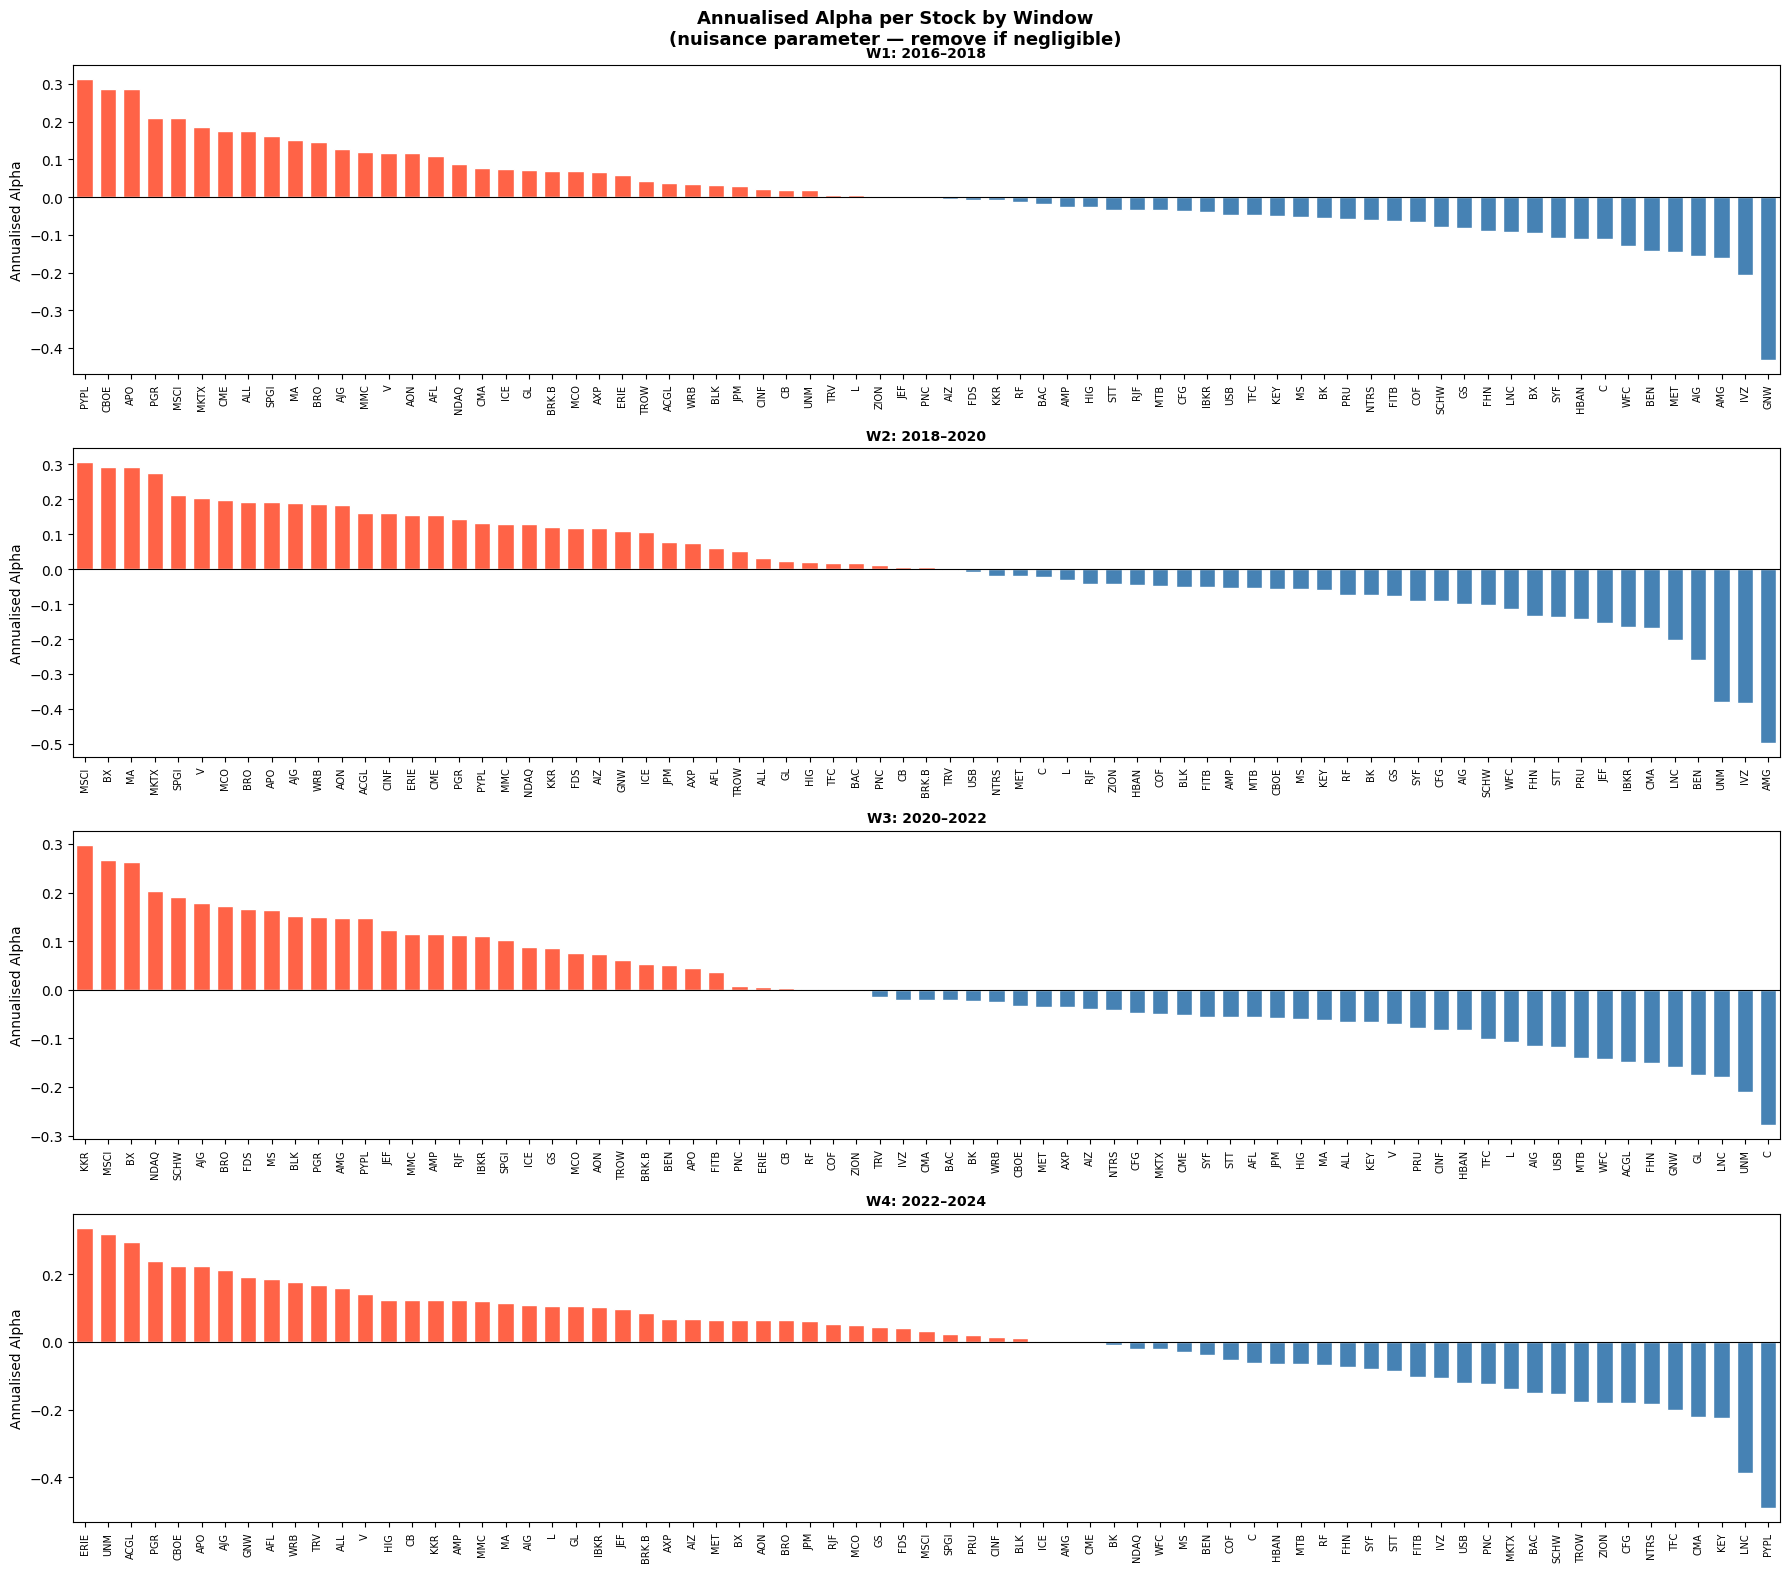

In [5]:
from IPython.display import display, Math
display(Math(
    r'r_{i,t} = \alpha_i + \beta_i \, r_{\mathrm{XLF},t} + \varepsilon_{i,t}'
    r'\qquad \mathrm{TE}_i = \hat{\sigma}(\varepsilon_i) \times \sqrt{252}'
))
display(Math(
    r'\text{Note: } \alpha_i \text{ is estimated to correct } \hat{\beta}_i '
    r'\text{and } R^2 \text{; conceptual model of interest remains } '
    r'r_{i,t} = \beta_i \, r_{\mathrm{XLF},t} + \varepsilon_{i,t}'
))

fig, axes = plt.subplots(len(windows), 1, figsize=(18, 4 * len(windows)))
fig.suptitle('Annualised Alpha per Stock by Window\n(nuisance parameter — remove if negligible)',
             fontsize=13, fontweight='bold')

for ax, w in zip(axes, windows):
    alpha_s = (
        df[df['window'] == w['label']]
        .set_index('stock')['alpha_ann']
        .sort_values(ascending=False)
    )
    colors = ['tomato' if v > 0 else 'steelblue' for v in alpha_s]

    ax.bar(alpha_s.index, alpha_s.values, color=colors, edgecolor='white', width=0.7)
    ax.axhline(0, color='black', lw=0.8)
    ax.set_title(w['label'], fontsize=10, fontweight='bold')
    ax.set_ylabel('Annualised Alpha')
    ax.tick_params(axis='x', rotation=90, labelsize=7)
    ax.set_xlim(-0.5, len(alpha_s) - 0.5)

plt.tight_layout()
plt.savefig('alpha_by_window.png', dpi=150, bbox_inches='tight')
plt.show()

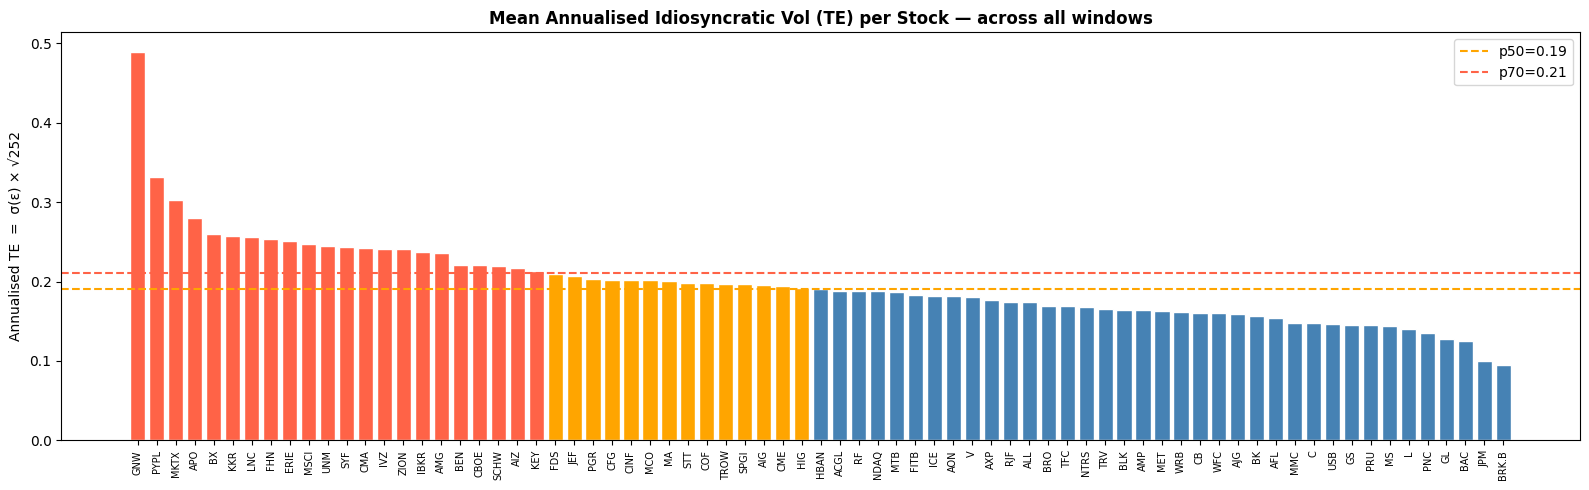

In [6]:
mean_te  = df.groupby('stock')['TE'].mean().sort_values(ascending=False)
p50, p70 = mean_te.quantile(0.50), mean_te.quantile(0.70)
colors   = ['tomato' if v > p70 else 'orange' if v > p50 else 'steelblue' for v in mean_te]

fig, ax = plt.subplots(figsize=(16, 5))
ax.bar(mean_te.index, mean_te.values, color=colors, edgecolor='white')
ax.axhline(p50, color='orange', lw=1.5, linestyle='--', label=f'p50={p50:.2f}')
ax.axhline(p70, color='tomato',  lw=1.5, linestyle='--', label=f'p70={p70:.2f}')
ax.set_title('Mean Annualised Idiosyncratic Vol (TE) per Stock — across all windows',
             fontweight='bold')
ax.set_ylabel('Annualised TE  =  σ(ε) × √252')
ax.tick_params(axis='x', rotation=90, labelsize=7)
ax.legend()
plt.tight_layout()
plt.savefig('mean_te_ranked.png', dpi=150, bbox_inches='tight')
plt.show()

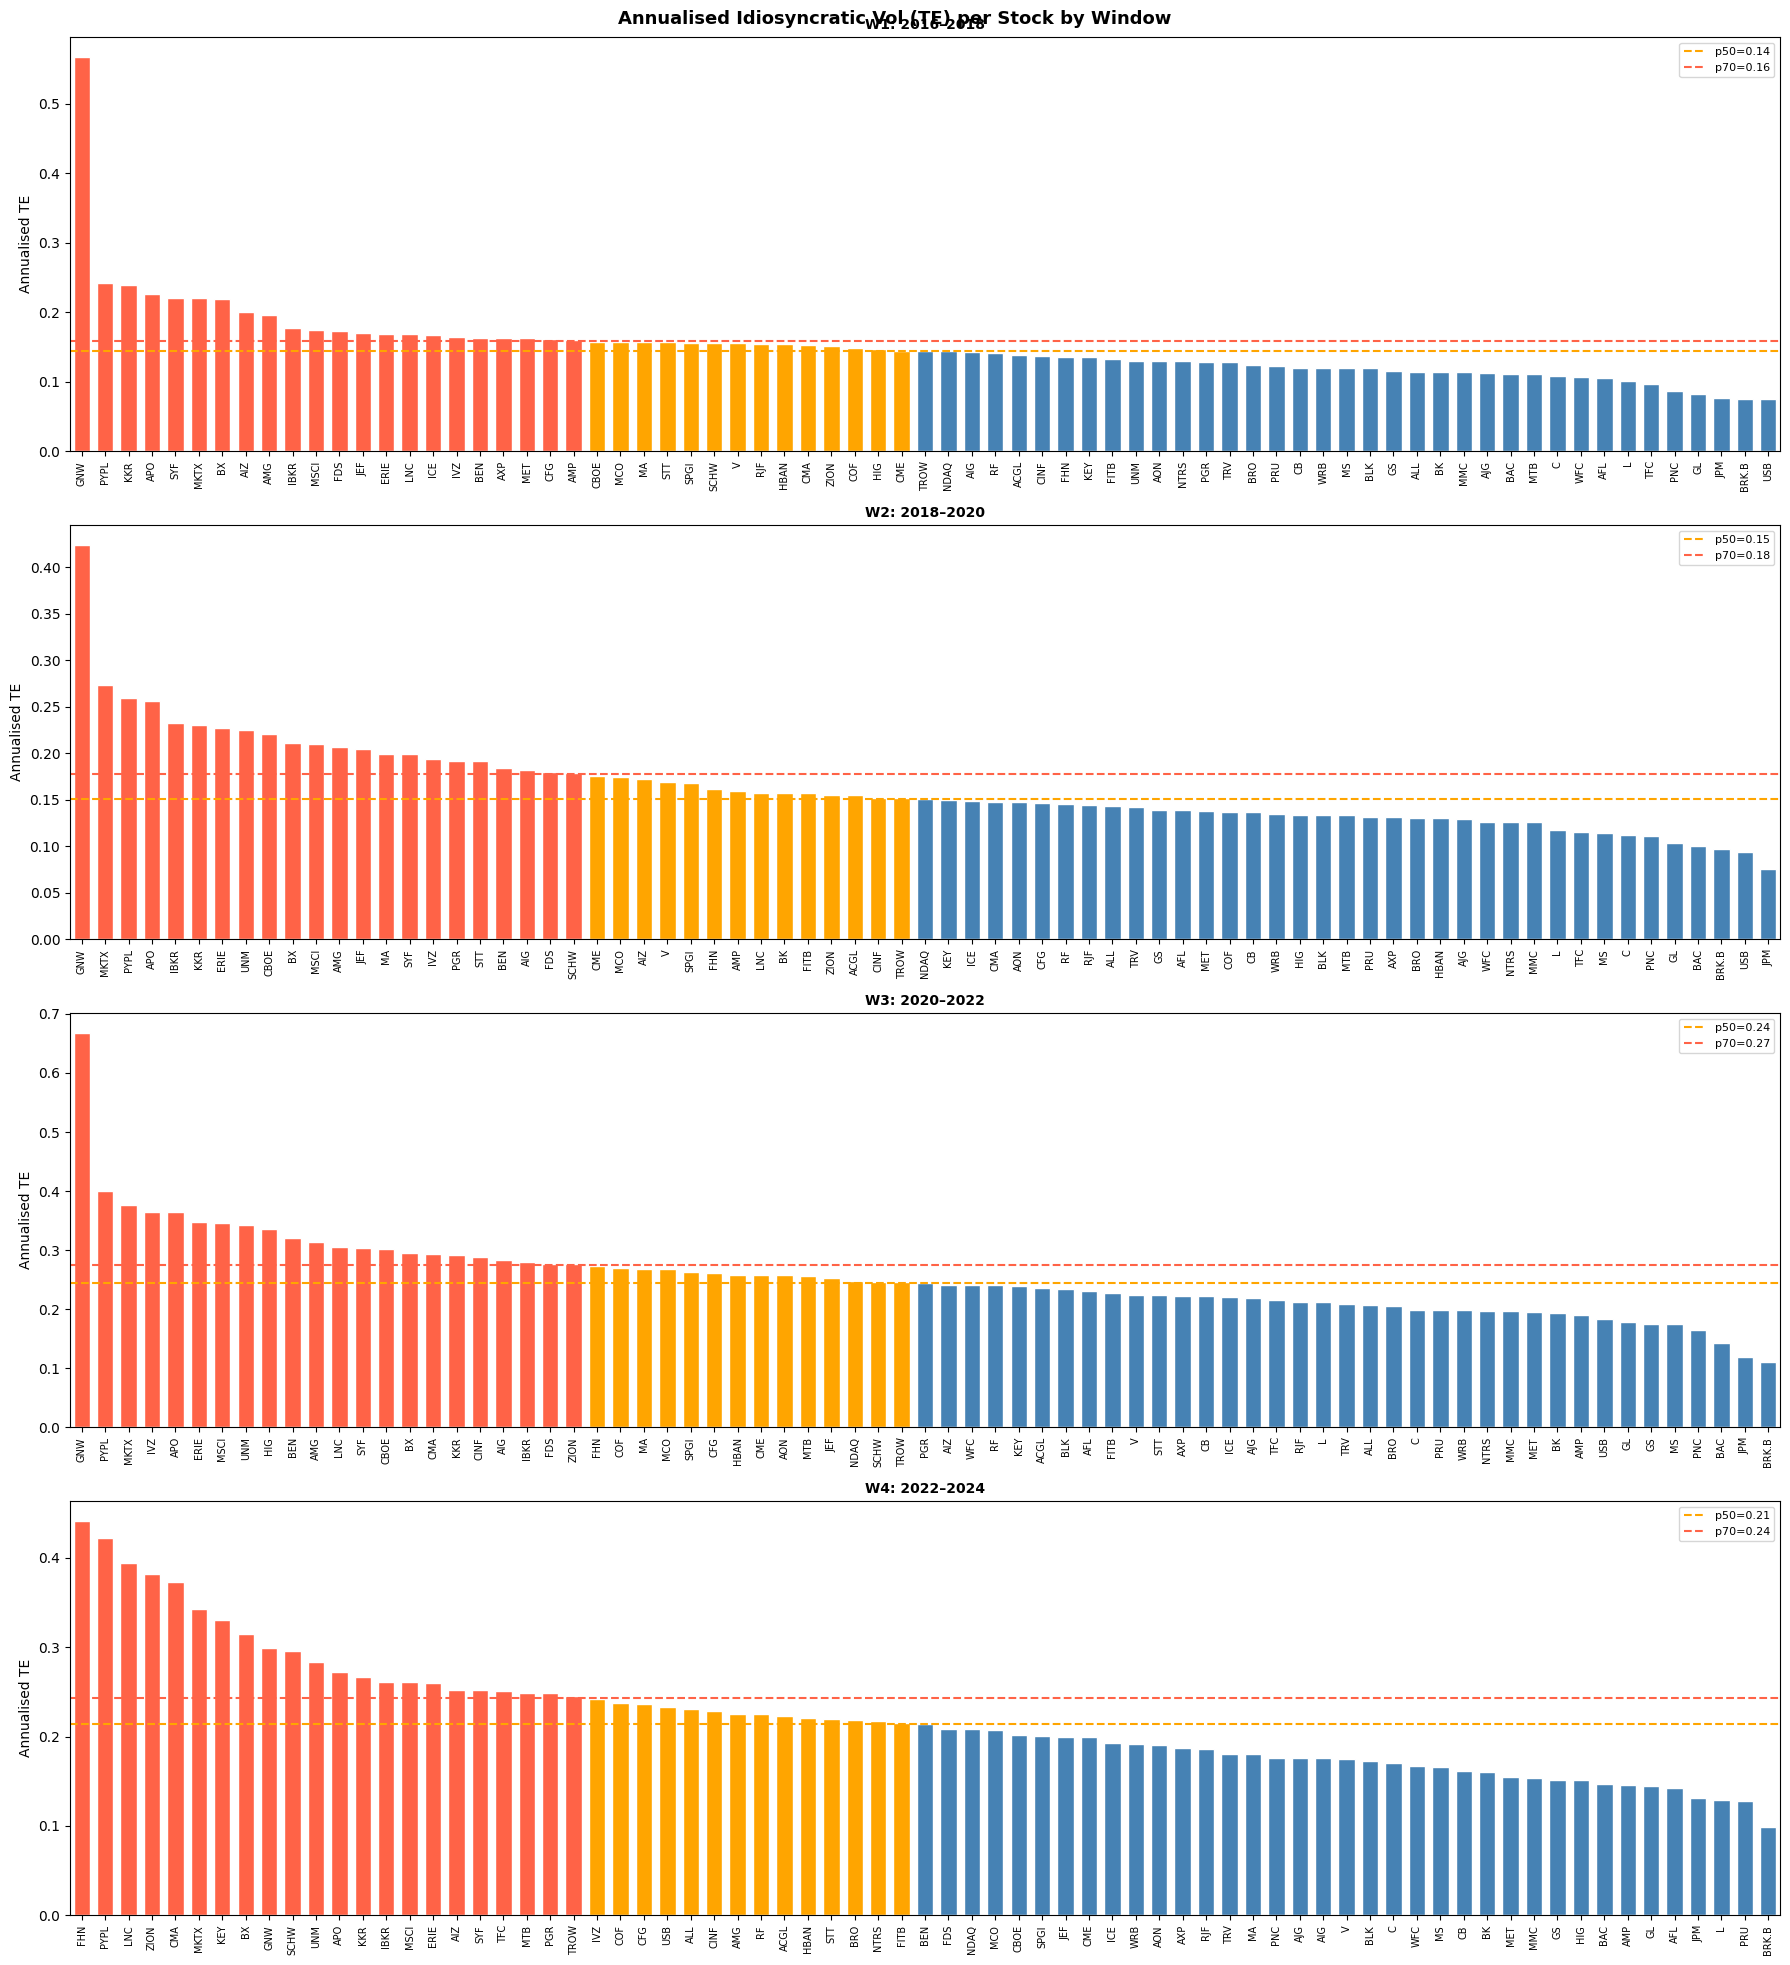

In [7]:
fig, axes = plt.subplots(len(windows), 1, figsize=(18, 5 * len(windows)))
fig.suptitle('Annualised Idiosyncratic Vol (TE) per Stock by Window',
             fontsize=13, fontweight='bold')

for ax, w in zip(axes, windows):
    te_s  = (
        df[df['window'] == w['label']]
        .set_index('stock')['TE']
        .sort_values(ascending=False)
    )
    p50, p70 = te_s.quantile(0.50), te_s.quantile(0.70)
    colors   = ['tomato' if v > p70 else 'orange' if v > p50 else 'steelblue' for v in te_s]

    ax.bar(te_s.index, te_s.values, color=colors, edgecolor='white', width=0.7)
    ax.axhline(p50, color='orange', lw=1.5, linestyle='--', label=f'p50={p50:.2f}')
    ax.axhline(p70, color='tomato',  lw=1.5, linestyle='--', label=f'p70={p70:.2f}')
    ax.set_title(w['label'], fontsize=10, fontweight='bold')
    ax.set_ylabel('Annualised TE')
    ax.tick_params(axis='x', rotation=90, labelsize=7)
    ax.set_xlim(-0.5, len(te_s) - 0.5)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('te_ranked_by_window.png', dpi=150, bbox_inches='tight')
plt.show()